In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
print("number of missing values per variable")
for column in df.columns:
    print("{} {}".format(column, df[column].isnull().sum()))

number of missing values per variable
diagnosis 0
radius_mean 0
texture_mean 0
perimeter_mean 0
area_mean 0
smoothness_mean 0
compactness_mean 0
concavity_mean 0
concave points_mean 0
symmetry_mean 0
fractal_dimension_mean 0
radius_se 0
texture_se 0
perimeter_se 0
area_se 0
smoothness_se 0
compactness_se 0
concavity_se 0
concave points_se 0
symmetry_se 0
fractal_dimension_se 0
radius_worst 0
texture_worst 0
perimeter_worst 0
area_worst 0
smoothness_worst 0
compactness_worst 0
concavity_worst 0
concave points_worst 0
symmetry_worst 0
fractal_dimension_worst 0


There is no missing values

We plot the correlations between the mean variables.

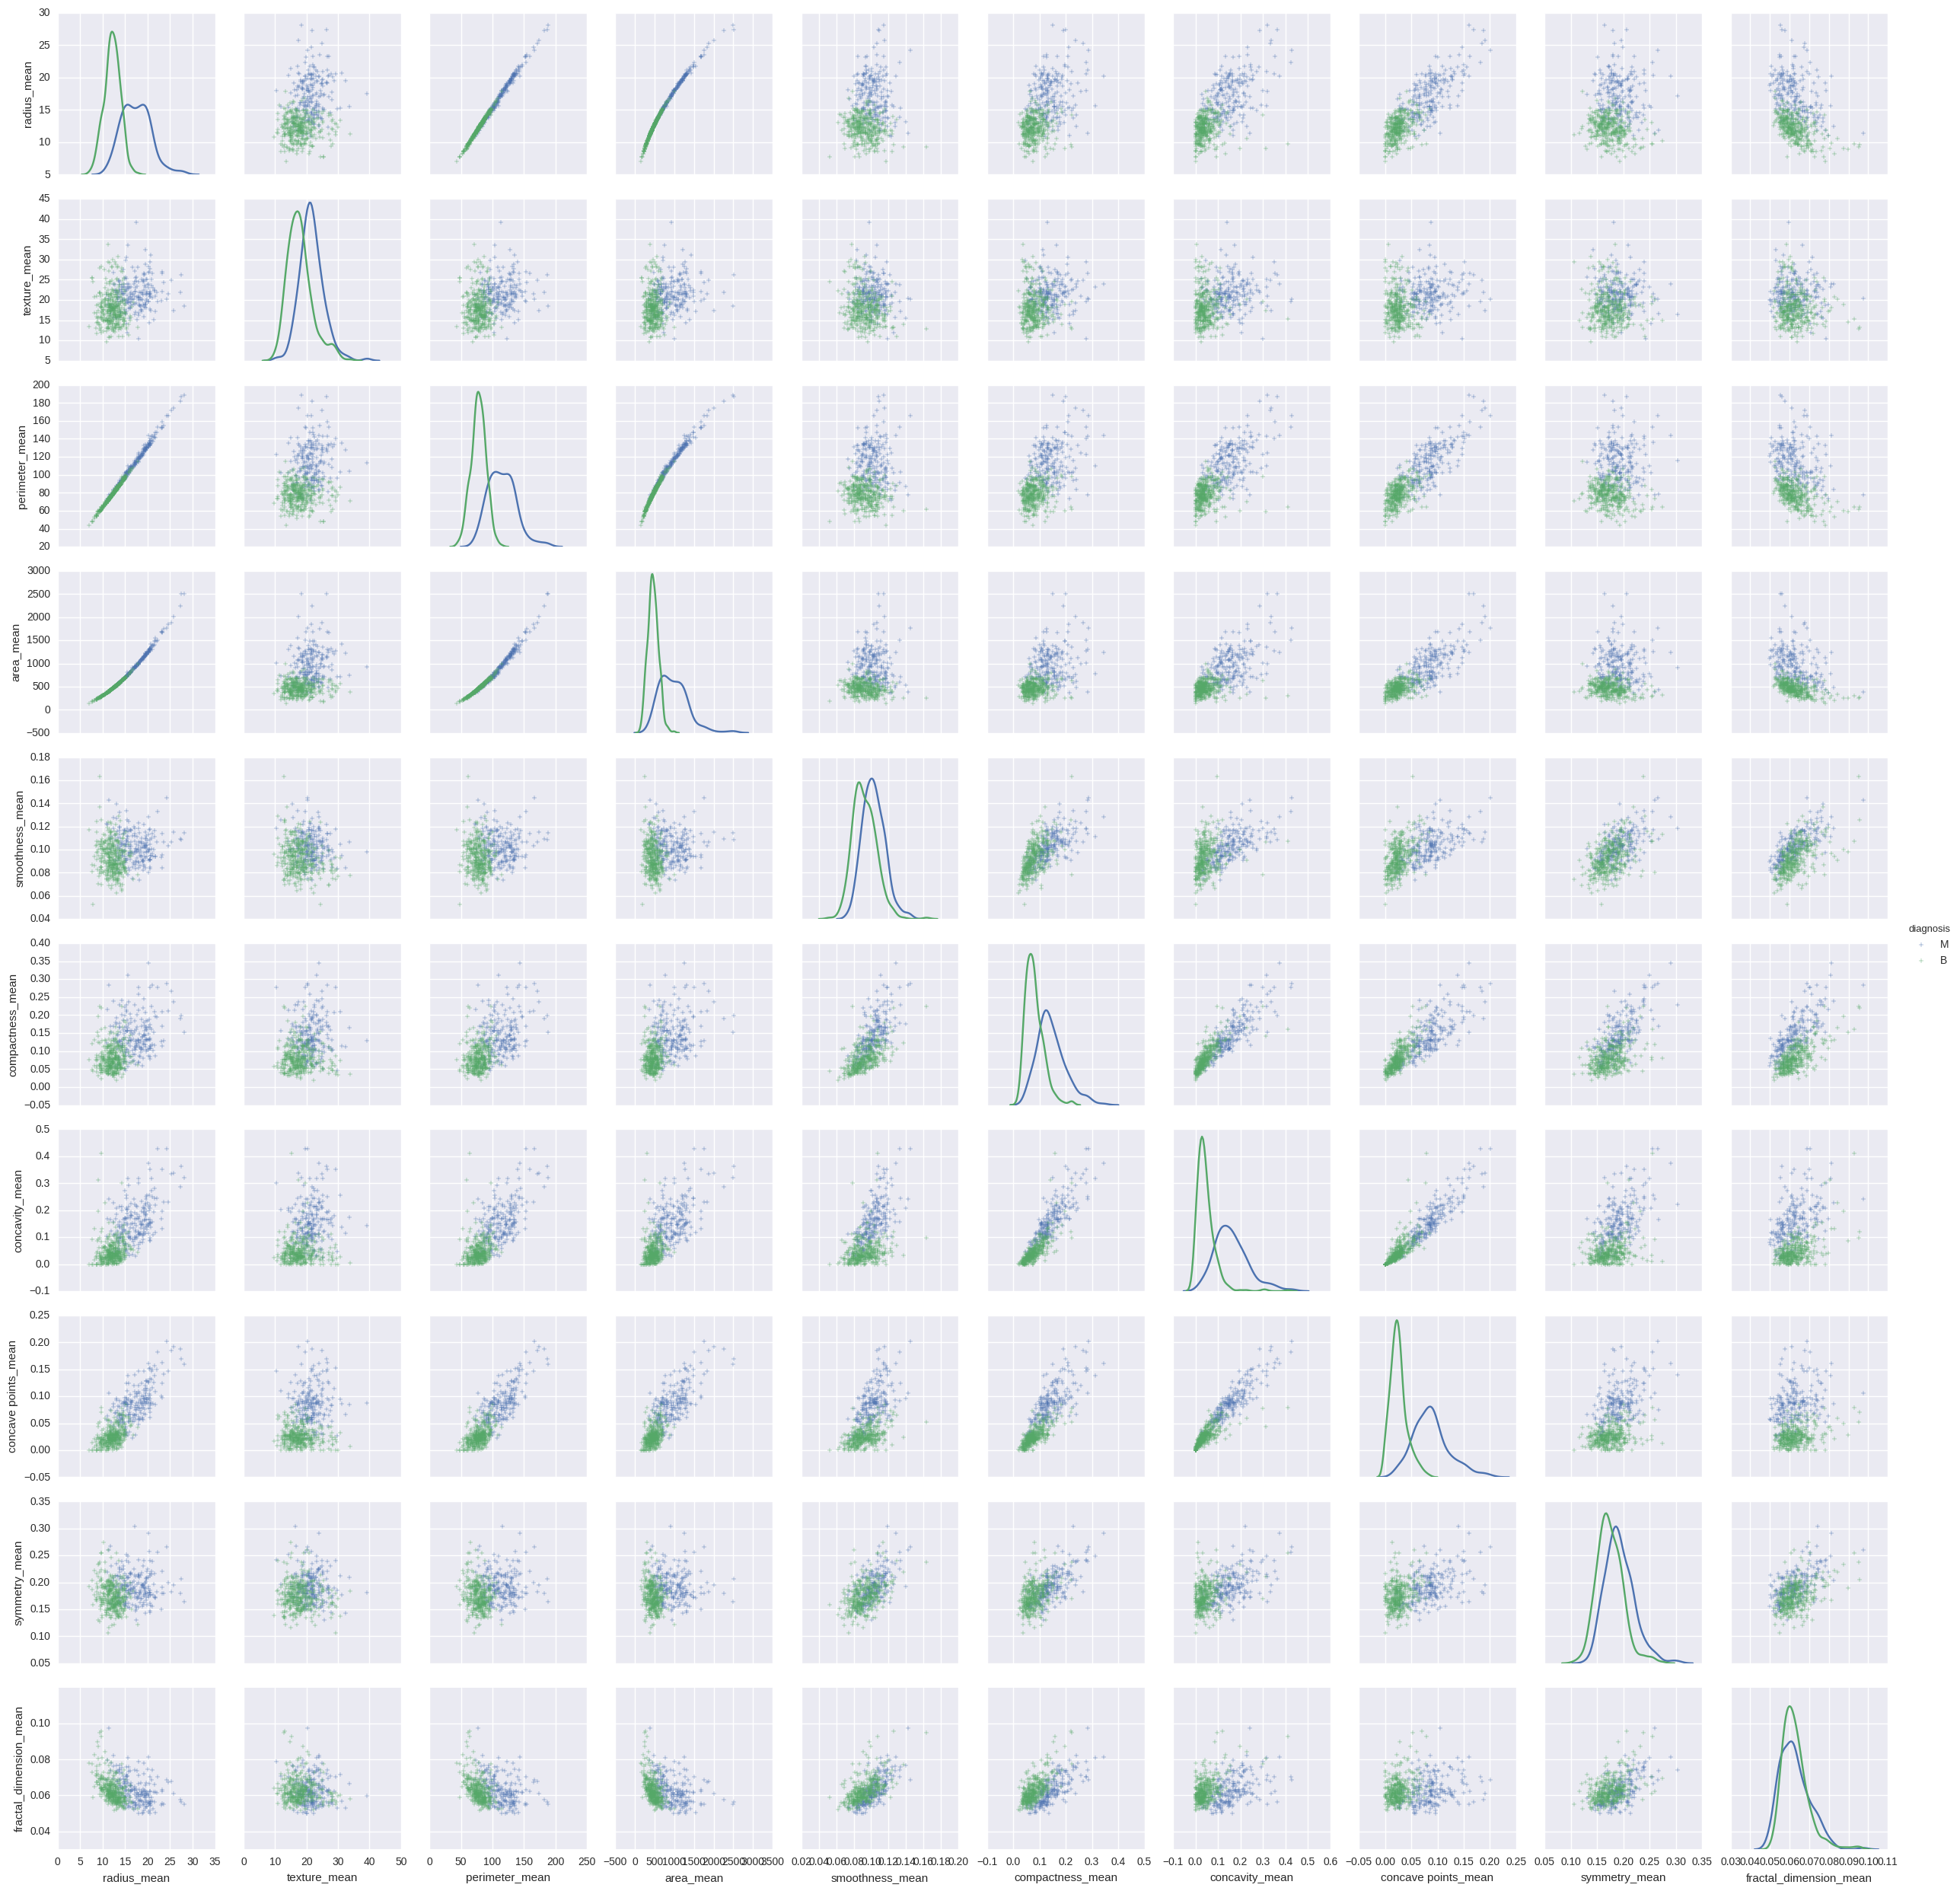

In [11]:
sns.pairplot(df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'diagnosis']], diag_kind="kde", markers="+", hue="diagnosis")

We observe that the distributions of the fractal dimension, the symmetry, the smoothness are similar for benign and malignant tumors so we discard those variables.

In [12]:
variables = ['radius_mean', 'texture_mean', 'perimeter_mean',
             'area_mean', 'compactness_mean', 'concavity_mean',
             'concave points_mean']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df[variables], df['diagnosis'], 
                                                    test_size=0.33, random_state=42)

y_train = np.ravel(label_binarize(y_train, classes=['B', 'M']))
y_test = np.ravel(label_binarize(y_test, classes=['B', 'M']))

# SVM 

In [95]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [99]:
parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(0.1, 100, 20)}
clf = GridSearchCV(svm.SVC(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': array([   0.1    ,    5.35789,   10.61579,   15.87368,   21.13158,
         26.38947,   31.64737,   36.90526,   42.16316,   47.42105,
         52.67895,   57.93684,   63.19474,   68.45263,   73.71053,
         78.96842,   84.22632,   89.48421,   94.74211,  100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
clf.best_params_

{'C': 68.452631578947376, 'kernel': 'linear'}

In [100]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.94148936170212771

# Random forest

In [18]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9468085106382979

### grid search

In [ ]:
parameters = {}

# Logistic regression

In [20]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9308510638297872

### grid search

In [ ]:
parameters = {"C" : np.logspace(10**(-2), 10**2, 20), "penalty": ["l1", "l2"]}
clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(X_train, y_train)